In [1]:
import numpy as np
import time
from scipy import misc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

In [2]:
M=1000
ite=10
block=[0,4,9]
#block=[0,1,2,3,4,5,6,7,8,9]
T=1
T_c=1
T_f=0.1
delta_c=torch.tensor(T_c/ite)
delta_f=torch.tensor(T_f/ite)
a=1
b=1
c=1
d=1
A=1
B=1
sigma=0.01
alpa=1
beta=1
neuron_model_psi=20
dim_n=2
up_lim=100
print(delta_c,delta_f)

tensor(0.1000) tensor(0.0100)


In [3]:
model_f= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [4]:
model_coarse = torch.load('model_N10_LQC.pth')

In [5]:
data=np.load('state_var_dic_N10.npz')
state_data = torch.tensor(data['state variable'])
sample=state_data[0]
print(sample)

tensor([[ 0.1000, 44.8863],
        [ 0.1000, 22.4774],
        [ 0.1000, 64.3961],
        ...,
        [ 0.1000, 45.2965],
        [ 0.1000, 68.1115],
        [ 0.1000, 35.9073]])


In [6]:
def update(x3,psi,z,i,delta):
    t=(x3[:,0]+(T_f/ite))
    #print(x3[:,1].shape,z[:,i].shape,psi.shape)
    x=x3[:,1]+(c*x3[:,1]+d*psi)*delta+sigma*torch.sqrt(delta)*z[:,i]
    up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
#     print('up shape=', up.shape)
    return up
    
def loss_func(x2,psi):
    loss=a*torch.pow(x2[:,1],2)+b*x2[:,1]+A*torch.pow(psi,2)+B*psi
    return loss

def loss_func_ter(x4,f,h,k,i):
    v_f=f[i+1]*torch.pow(x4[:,1],2)+h[i+1]*x4[:,1]+k[i+1]
    return v_f

def unit(x1,model,i,delta):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi,z,i,delta)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(model,delta,f,h,k):
    loss_total=0.0    
    for num in range(len(block)):       
        loss=torch.zeros(M,ite)
        psi=torch.zeros(M,ite)
        block_pos=block[num]
        t=torch.zeros([M,1])+block_pos*delta_c
        element=state_data[block_pos,:,1].reshape(M,1)
        u=torch.cat((t,element),dim=1)
        for i in range(ite+1):
            if(i<ite):
                psi_run,loss_run,u_run=unit(u,model,i,delta)
                #print('los func=',psi_run.shape,loss_run.shape)
                loss[:,i]=loss_run
                #print(loss)
                psi[:,i]=psi_run
                #print(psi)
                u=u_run
              #print(u)
            else:
                loss_ter=loss_func_ter(u,f,h,k,block_pos)
              #print('ter',loss_ter.shape)
            #print(torch.sum(loss,dim=1))
        loss=torch.sum(loss,dim=1)*delta+loss_ter
        loss_total=loss_total+loss
    return torch.mean(loss_total)

In [7]:
# t=torch.zeros([M,1])
# #x=torch.FloatTensor(M,1).uniform_(0.0,up_lim)
# element=state_data[block,:,1].reshape(1000,1)
z=torch.randn(size=(M, ite+1))
# x=torch.cat((t,element),dim=1)
# print('coarse soution=',c_soln[0])
# print(x.shape)

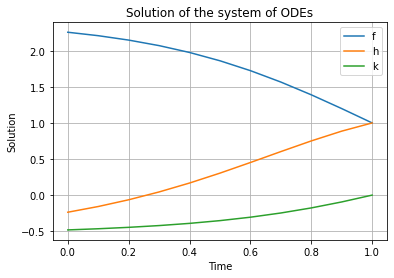

In [8]:
def system_of_odes(t, y):
    dydt = [
        a+2*c*y[0]-(d**2*y[0]**2)/A,                 # df/dt = a+2cf-d^2*f^2/A; f(0)=alpa
        b-(B+d*y[1])*d*y[0]/A,                       # dh/dt = b-(B+dh)fd/A; h(0)=beta
        sigma**2*y[0]-(B+d*y[1])**2/(4*A)        # dk/dt = sigma^2*f-(B+dh)^2/4A; k(0)=0
    ]
    return dydt

# Initial conditions
initial_conditions = [alpa, beta, 0]  # Initial values for y1, y2, and y3

# Time span
t_span = (0, T_c)  # Start and end time

# Solve the system of ODEs
sol = solve_ivp(system_of_odes,t_span, initial_conditions, t_eval=np.linspace(0, T_c, ite+1))

f=np.flip(sol.y[0])
h=np.flip(sol.y[1])
k=np.flip(sol.y[2])
# Plot the solution
plt.plot(sol.t, f, label='f') 
plt.plot(sol.t, h, label='h')
plt.plot(sol.t, k, label='k')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution of the system of ODEs')

plt.legend()
plt.grid(True)
plt.show()

In [9]:
start=time.time()
lr1 = 8e-3
max_epoch = 3000
cost_ar=[]
optimizer = optim.Adam(model_f.parameters(), lr1)

#print(psi.shape)
for epoch in range(max_epoch):
  optimizer.zero_grad()
  cost=loss_func_total(model_f,delta_f,f,h,k)
  cost.backward()
  optimizer.step()
  cost_ar.append(cost)
  #print(loss.item())
  if (epoch % 100==0):
    print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
end=time.time()
total_time=end-start
print('time elapsed=',total_time)

At epoch 0 the mean cost is 11560.7119140625.
At epoch 100 the mean cost is 9345.2177734375.
At epoch 200 the mean cost is 9323.654296875.
At epoch 300 the mean cost is 9307.34375.
At epoch 400 the mean cost is 9295.9931640625.
At epoch 500 the mean cost is 9292.9892578125.
At epoch 600 the mean cost is 9292.0224609375.
At epoch 700 the mean cost is 9290.5341796875.
At epoch 800 the mean cost is 9287.9580078125.
At epoch 900 the mean cost is 9287.0859375.
At epoch 1000 the mean cost is 9286.8173828125.
At epoch 1100 the mean cost is 9286.4609375.
At epoch 1200 the mean cost is 9285.9853515625.
At epoch 1300 the mean cost is 9285.78515625.
At epoch 1400 the mean cost is 9285.6787109375.
At epoch 1500 the mean cost is 9285.6162109375.
At epoch 1600 the mean cost is 9285.576171875.
At epoch 1700 the mean cost is 9285.5419921875.
At epoch 1800 the mean cost is 9285.515625.
At epoch 1900 the mean cost is 9285.494140625.
At epoch 2000 the mean cost is 9285.470703125.
At epoch 2100 the mean c

In [10]:
M2=10
x_ar=[]
z1=torch.randn(size=(M2,ite))
t_test=torch.zeros([M2,1])
x1=torch.linspace(0.1*up_lim,0.95*up_lim, steps=M2).unsqueeze(1)
x_test=torch.cat((t_test,x1),dim=1)
#pred_soln=torch.zeros(M2,ite)
pred_soln=[]
for i in range(ite):
    for j in range(ite):        
        x_ar.append(x_test[:,1].numpy())
        soln_pred=model_f.eval()(x_test).squeeze(1).detach()
        #print(soln_pred)
        #pred_soln[:,i]=soln_pred
        pred_soln.append(soln_pred.numpy())
        x_test=update(x_test,soln_pred,z1,j,delta_f)
#         if(torch.floor(x_test[0,0]*10)!=0):
#             x_test[:,0]=0.0
#         print(x_test)
        #x_ar.append(x_test[:,1].numpy())
state_var=np.squeeze(np.array(x_ar))
state_var=state_var.transpose()
pred=np.squeeze(np.array(pred_soln))
pred=pred.transpose()
# print(pred.shape,state_var.shape)
# print(pred[0],state_var[0])

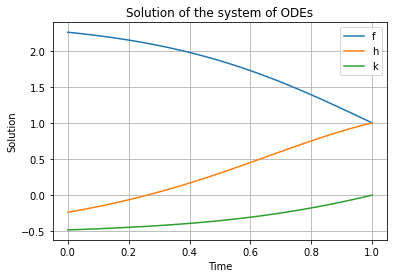

In [11]:
# Define the system of ODEs
def system_of_odes(t, y):
    dydt = [
        a+2*c*y[0]-(d**2*y[0]**2)/A,                 # df/dt = a+2cf-d^2*f^2/A; f(0)=alpa
        b-(B+d*y[1])*d*y[0]/A,                       # dh/dt = b-(B+dh)fd/A; h(0)=beta
        sigma**2*y[0]-(B+d*y[1])**2/(4*A)        # dk/dt = sigma^2*f-(B+dh)^2/4A; k(0)=0
    ]
    return dydt

# Initial conditions
initial_conditions = [alpa, beta, 0]  # Initial values for y1, y2, and y3

# Time span
t_span = (0, T_c)  # Start and end time

# Solve the system of ODEs
sol = solve_ivp(system_of_odes,t_span, initial_conditions, t_eval=np.linspace(0, T_c, 100))

f=np.flip(sol.y[0])
h=np.flip(sol.y[1])
k=np.flip(sol.y[2])
# Plot the solution
plt.plot(sol.t, f, label='f')
plt.plot(sol.t, h, label='h')
plt.plot(sol.t, k, label='k')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution of the system of ODEs')

plt.legend()
plt.grid(True)
plt.show()

In [12]:
def optimal_soln(x,f,h):
    u=-(B+d*(2*x*f+h))/(2*A)
    return u

def value_func(x,f,h,k):
    V=f*x**2+h*x+k
    return V

def total_cost(x,u):
    cost_run=0.0
    for i in range(ite+1):
        if(i<ite):
            cost_run=cost_run+a*x[i]**2+b*x[i]+A*u[i]**2+B*u[i]
        else:
            cost_ter=alpa*x[i]**2+beta*x[i]
    return cost_run*delta_f.numpy()+cost_ter 

In [18]:
t_eval=np.linspace(0,T,ite*ite)
u=np.zeros([M2,ite*ite])
for i in range(M2):
    #print('state variable',state_var[i])
    u[i]=optimal_soln(state_var[i],f,h)
#     print('\n True solution',u[i])
#     true_cost=total_cost(state_var[i],u[i])
#     print('\n True cost=',true_cost)
#     print('\n Predicted solution',pred[i])
#     pred_cost=total_cost(state_var[i],pred[i])
#     print('\n Predicted cost=',pred_cost)
#     print('Percent Error in cost=',np.abs(100*(np.abs(true_cost)-np.abs(pred_cost))/true_cost),'%\n')

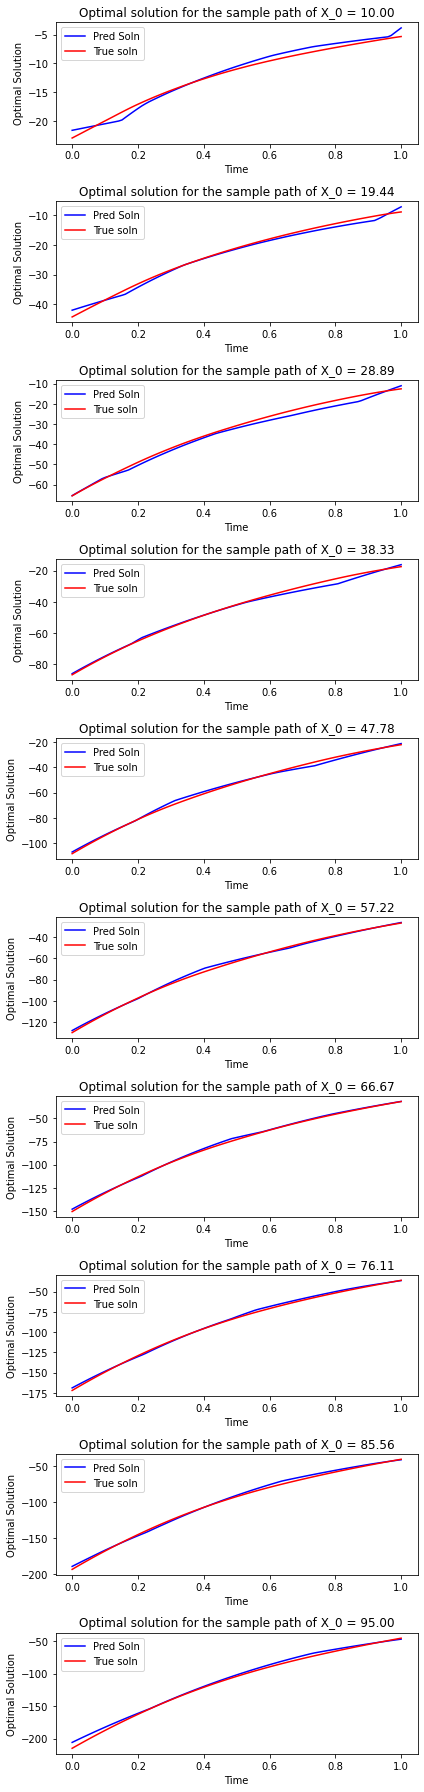

In [19]:
fig, axs = plt.subplots(M2,1, figsize=(6, 25))

# Plot x vs y and x vs z on each subplot
for i, ax in enumerate(axs):
    ax.plot(t_eval,pred[i], color='b', label='Pred Soln')
    ax.plot(t_eval,u[i], color='r', label='True soln')
    ax.set_xlabel('Time')
    ax.set_ylabel('Optimal Solution')
    ax.set_title(f'Optimal solution for the sample path of X_0 = {state_var[i,0]:.2f}')
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

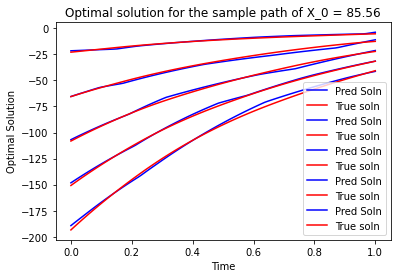

In [15]:
import matplotlib
matplotlib.use('Qt5Agg')

for i in range(0, M2, 2):
    plt.plot(t_eval, pred[i], color='b', label='Pred Soln')
    plt.plot(t_eval, u[i], color='r', label='True soln')
    plt.xlabel('Time')
    plt.ylabel('Optimal Solution')
    plt.title(f'Optimal solution for the sample path of X_0 = {state_var[i, 0]:.2f}')
    plt.legend()
    plt.show()

In [16]:
# t_eval=np.linspace(0,T_c,100)
# u=optimal_soln(state_var,f,h)
# V=value_func(state_var,f,h,k)

# print('state variable',state_var)
# print('\n True solution',u)
# true_cost=total_cost(state_var,u)
# print('\n True cost=',true_cost)
# print('\n Predicted solution',pred)
# pred_cost=total_cost(state_var,pred)
# print('\n Predicted cost=',pred_cost)
# print('Absolute Error',np.abs(u)-np.abs(pred))
# print('Percent Error in cost=',np.abs(100*(np.abs(true_cost)-np.abs(pred_cost))/true_cost),'%\n')

In [17]:
# plt.figure(figsize=(14,6))
# plt.plot(t_eval,pred, color='b', label='Pred Soln')
# plt.plot(t_eval,u, color='r', label='True soln')
# plt.xlabel('Time steps')
# plt.ylabel('Optimal Solution')
# plt.title(f'Optimal solution for the sample path of X_0 = {state_var[0]:.2f}')
# plt.legend()
# plt.show()